## NYC road networks with osmnx
### with applications to finding nodes inside a polygon

Last edit: 10/26 by JHC

[osmnx](https://geoffboeing.com/publications/osmnx-complex-street-networks/) is a library for loading and working with street networks from OpenStreetMaps.

This notebook illustrates how to load street network data and some methods for speeding up intersections (finding nodes within a polygon) using geopandas.

This content is closely adapted from the notebook "r-tree spatial indexing with Python and geopandas" for quickly finding points within a polygon using an r-tree spatial index.  All by Geoff Boeing, from his [Urban Data Science](https://github.com/gboeing/urban-data-science) course.

In [84]:
import osmnx as ox, matplotlib.pyplot as plt, pandas as pd, geopandas as gpd
from descartes import PolygonPatch
from shapely.geometry import Point, Polygon, MultiPolygon
import networkx as nx

from IPython.display import IFrame
import folium

%matplotlib inline

## First example
### Create a polygon for the boundary of a city, and points representing street intersections around it

Get the boundary of some city

In [2]:
gdf = ox.gdf_from_place('New York City, NY, USA')

In [3]:
gdf

,bbox_east,bbox_north,bbox_south,bbox_west,geometry,place_name
0,-73.700181,40.916179,40.477399,-74.25909,"(POLYGON ((-74.25909 40.497207, -74.259028 40....","New York City, New York, USA"


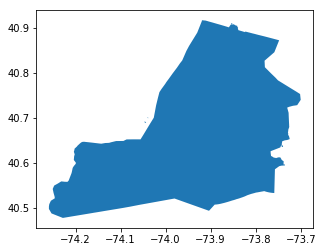

In [6]:
gdf.plot();

Pull in the street network data within this bounding box

In [7]:
west, south, east, north = gdf.unary_union.buffer(0.1).bounds
G = ox.graph_from_bbox(north, south, east, west, network_type='drive', retain_all=True)

In [8]:
G

In [9]:
G.size()

447664

The road network is saved as a networkx multidigraph. Each node is an intersection.
We can get lat-long points for each intersection

In [10]:
xy = [(data['x'], data['y']) for node, data in G.nodes(data=True)]
x, y = list(zip(*xy))

### Road intersections
Turn the lat-long points into a geodataframe

In [11]:
gdf_nodes = gpd.GeoDataFrame(data={'x':x, 'y':y})
gdf_nodes.crs = gdf.crs
gdf_nodes.name = 'nodes'
gdf_nodes['geometry'] = gdf_nodes.apply(lambda row: Point((row['x'], row['y'])), axis=1)

In [12]:
gdf_nodes.head(2)

,x,y,geometry
0,-74.103749,40.691024,POINT (-74.1037491 40.6910239)
1,-73.981056,40.645752,POINT (-73.981056 40.645752)


We can plot the geodataframe but Geoff Boeing has a [notebook](https://github.com/gboeing/urban-data-science/blob/master/19-Spatial-Analysis-and-Cartography/geopandas-plotting-speed.ipynb) showing that plotting with matplotlib can be *much* faster for large dataframes.  See methods later in notebook. 

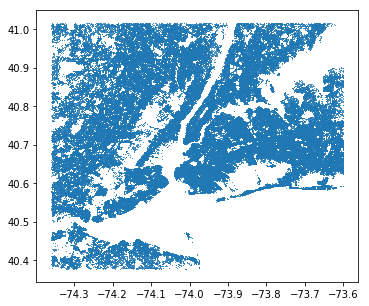

In [13]:
gdf_nodes.plot(markersize=1, linewidth=0, figsize=(8,5));

Let's zoom in on the Jackson Heights neighborhood

In [14]:
jhbounds = [-73.8987, -73.8701, 40.7470, 40.7600]

def clip(gdf, bd=jhbounds):
    return ( (gdf.x > bd[0]) & (gdf.x < bd[1]) & (gdf.y > bd[2]) & (gdf.y < bd[3]) )

In [15]:
jh_nodes = gdf_nodes[clip(gdf_nodes, bd=jhbounds)]

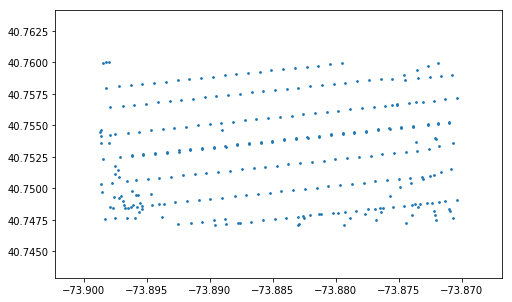

In [16]:
jh_nodes.plot(markersize=3, figsize=(8,5));

Make the geometry a multipolygon if it's not already  (not sure why this is needed).

In [17]:
geometry = gdf['geometry'].iloc[0]
if isinstance(geometry, Polygon):
    geometry = MultiPolygon([geometry])

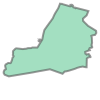

In [18]:
gdf['geometry'].iloc[0]

In [19]:
gdf

,bbox_east,bbox_north,bbox_south,bbox_west,geometry,place_name
0,-73.700181,40.916179,40.477399,-74.25909,"(POLYGON ((-74.25909 40.497207, -74.259028 40....","New York City, New York, USA"


### Got the data, now visualize the points and the polygon

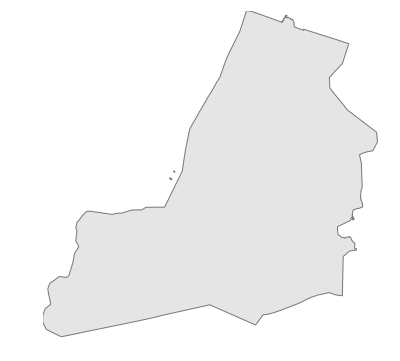

In [20]:
# plot the city
west, south, east, north = gdf.unary_union.bounds
fig, ax = plt.subplots(figsize=(6,6))
for polygon in geometry:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.5, zorder=2)
    ax.add_patch(patch)
    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()

### Plot the intersections and the city

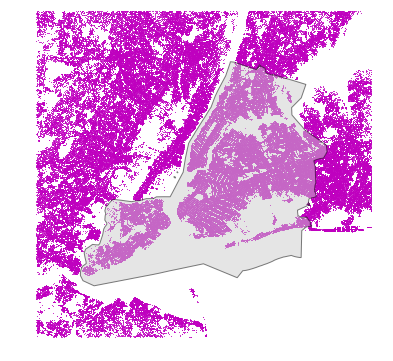

In [21]:
west, south, east, north = gdf_nodes.unary_union.bounds
fig, ax = plt.subplots(figsize=(6,6))
for polygon in geometry:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.5, zorder=2)
    ax.add_patch(patch)

ax.scatter(x=gdf_nodes['x'], y=gdf_nodes['y'], s=1, c='m', linewidth=0, zorder=1)
    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()

### Create a spatial index and find the points within the polygon

The idea in what follows is that we have road network for an area much larger than the NYC polygon.

We want to find the road intersections that are inside the NYC polygon only.

To save ourselves from checking if every node is inside the NYC polygon we do it in steps. First we ask if intersections are within a rectangular bounding box for the city.  Call these `possible_matches`. This will include all the intersections in the city but also quite a few 'false positives' -- outside the city polygon but inside the bounding box (for example parts of Eastern NJ). So we then look for more `precise_matches`.  This two step approach presumably saves time.

The first step is to create a spatial index (I think it's using Rtree) to presumably speed up searches by not having to search every point everytime we look for an interection.

In [22]:
sindex = gdf_nodes.sindex

In [23]:
sindex.bounds

[-74.359083, 40.377539, -73.600216, 41.016175]

In [24]:
possible_matches_index = list(sindex.intersection(geometry.bounds))
possible_matches = gdf_nodes.iloc[possible_matches_index]
precise_matches = possible_matches[possible_matches.intersects(geometry)]

So we found a large number of 'possible matches' (i.e. including false positives)

In [25]:
possible_matches.shape

(98596, 3)

In [26]:
precise_matches.shape

(55392, 3)

In [27]:
points_within_geometry = precise_matches
points_outside_geometry = gdf_nodes[~gdf_nodes.isin(points_within_geometry)]

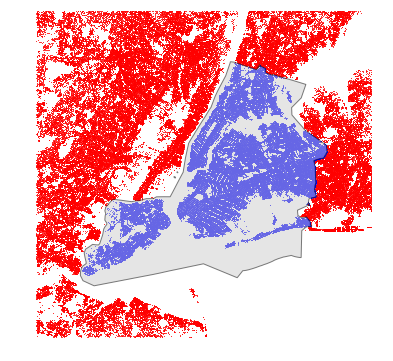

In [28]:
# plot the cut-up city
fig, ax = plt.subplots(figsize=(6,6))
for polygon in geometry:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.5, zorder=3)
    ax.add_patch(patch)

ax.scatter(x=points_outside_geometry['x'], y=points_outside_geometry['y'], s=1, c='r', linewidth=0, zorder=1)
ax.scatter(x=points_within_geometry['x'], y=points_within_geometry['y'], s=1, c='b', linewidth=0, zorder=2)
    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()

## Another yet faster approach 

Similar to the above but first dividing the map into subpolygons...presumably to reduce the number of false positives by having tighter fitting bounding boxes.

In [29]:
# quadrat_width is in the units the geometry is in, so we'll do a tenth of a degree
geometry_cut = ox.quadrat_cut_geometry(geometry, quadrat_width=0.1)

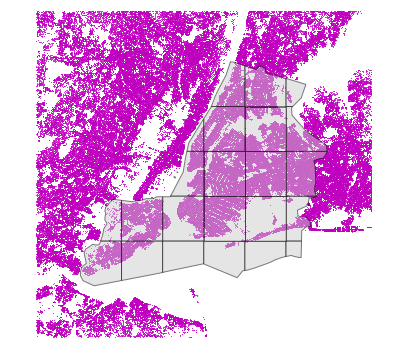

In [30]:
# plot the cut-up city
fig, ax = plt.subplots(figsize=(6,6))
for polygon in geometry_cut:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.5, zorder=2)
    ax.add_patch(patch)

ax.scatter(x=gdf_nodes['x'], y=gdf_nodes['y'], s=1, c='m', linewidth=0, zorder=1)
    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()

### Create a spatial index and find points within the sub-polygons

In [31]:
# find the points that intersect with each subpolygon and add them to points_within_geometry
points_within_geometry = pd.DataFrame()
for poly in geometry_cut:
    # buffer by the <1 micron dist to account for any space lost in the quadrat cutting
    # otherwise may miss point(s) that lay directly on quadrat line
    poly = poly.buffer(1e-14).buffer(0)

    # find approximate matches with r-tree, then precise matches from those approximate ones
    possible_matches_index = list(sindex.intersection(poly.bounds))
    possible_matches = gdf_nodes.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(poly)]
    points_within_geometry = points_within_geometry.append(precise_matches)

In [32]:
# drop duplicate points, if buffered poly caused an overlap on point(s) that lay directly on a quadrat line
points_within_geometry = points_within_geometry.drop_duplicates(subset=['x', 'y'])
points_outside_geometry = gdf_nodes[~gdf_nodes.isin(points_within_geometry)]

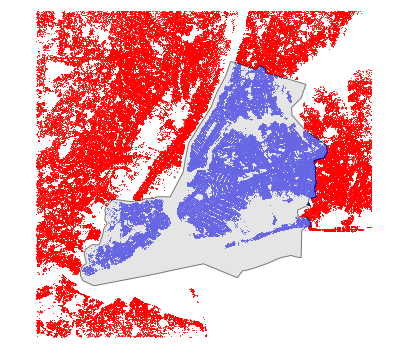

In [33]:
# plot the city and points within/outside
fig, ax = plt.subplots(figsize=(6,6))
for polygon in geometry:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.5, zorder=3)
    ax.add_patch(patch)

ax.scatter(x=points_outside_geometry['x'], y=points_outside_geometry['y'], s=1, c='r', linewidth=0, zorder=1)
ax.scatter(x=points_within_geometry['x'], y=points_within_geometry['y'], s=1, c='b', linewidth=0, zorder=2)
    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()

### More cool osmnx stuff


### Geocoding and shortest routes

In [34]:
hunter = ox.geocode('100-140 E 68th St, NY 10065')
themet = ox.geocode('1001 5th Ave, New York, NY 10028')

In [35]:
hunter, themet

((40.768412, -73.965604), (40.77861005, -73.9622136210297))

In [36]:
upper_east = (40.774177, -73.962950)
G = ox.graph_from_point(upper_east, distance=1500)

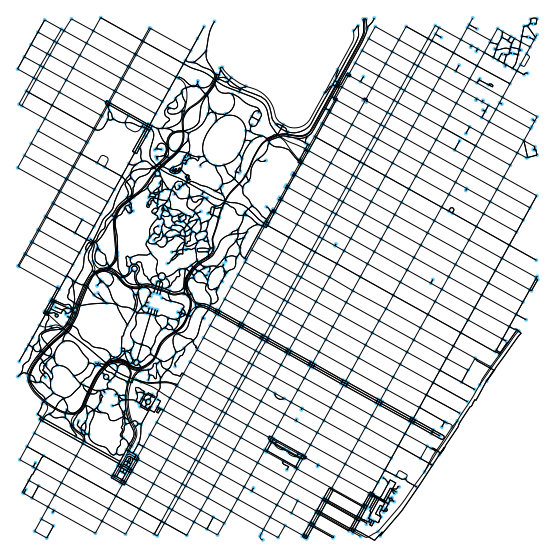

In [37]:
ox.plot_graph(G, fig_height=10, fig_width=10, edge_color='black');

#### Find the nearest node to a coordinate

In [40]:
hunter_node = ox.get_nearest_node(G, hunter, method='euclidean')
themet_node = ox.get_nearest_node(G, themet, method='euclidean')

#### Find the shortest route along the network
and plot the results.  Note the `route` is found using the `networkx` library.  The route will be a list of nodes which we then 

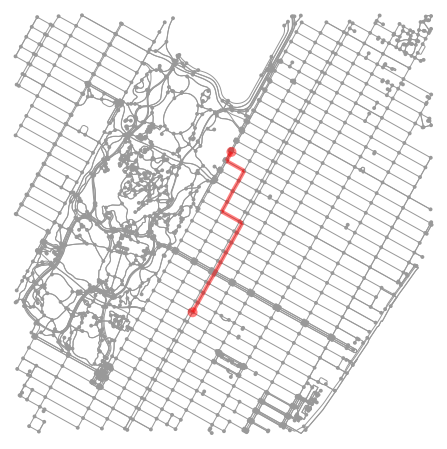

In [39]:
route = nx.shortest_path(G, hunter_node,  themet_node)
ox.plot_graph_route(G, route, fig_height=8, fig_width=8);

### One way and two way traffic

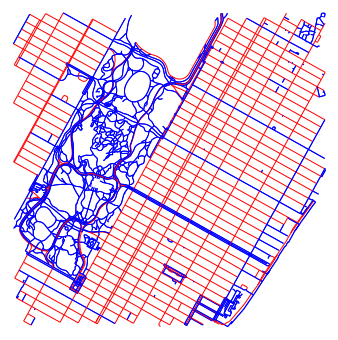

In [42]:
ec = ['r' if data['oneway'] else 'b' for u, v, key, data in G.edges(keys=True, data=True)]
ox.plot_graph(G, node_size=0, edge_color=ec);

### Plot osmnx map with folium

We can plot the network map onto a folium slippy map

In [89]:
graph_map = ox.plot_graph_folium(G, popup_attribute='name', edge_width=2,tiles='OpenStreetMap')

and add the route we calculated from the Met to Hunter College on top of that.  And since the object returned is a folium map, we're free to add additional features such as markers.

In [90]:
route_graph_map = ox.plot_route_folium(G, route, route_map=graph_map, popup_attribute='length')

In [91]:
folium.Marker(location = [hunter[0], hunter[1]], popup = 'Hunter College').add_to(route_graph_map)
folium.Marker(location = [themet[0], themet[1]], popup = 'Hunter College').add_to(route_graph_map);

In [92]:
filepath = 'foliumgraph.html'
graph_map.save(filepath)

The folium map should appear below (and saved to [foliumgraph.html](foliumgraph.html)).  Note that this is a folium Map so we can add other objects to it such as markers.

In [93]:
IFrame(filepath, width=600, height=500)